<h1 style="color:lightblue;"><b><u>Import Library</u></b></h1>

<h3 style="color:lightblue;">Kita akan mengimpor pandas, matplotlib, dan beberapa "alat" khusus dari statsmodels.</h3>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# mengimpor library untuk time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metrik evaluasi
from sklearn.metrics import mean_squared_error

# Mengatur 'style' default untuk semua grafik
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6) # Atur ukuran default grafik

print("Libraries berhasil di-import.")

Libraries berhasil di-import.


<h1 style="color:lightblue;"><b><u>Memuat Data</u></b></h1>

<h3 style="color:lightblue;">Kita ubah 9.994 baris transaksi menjadi data bulanan.</h3>

In [22]:
processed_data_path = "../data/SuperStore_Processed.csv"
df = pd.read_csv(processed_data_path, parse_dates=['Order_Date'])

print(f"Data asli dimuat. Jumlah baris: {len(df)}")

# 1. Kita hanya butuh 'Order_Date' dan 'Sales'
ts_data = df[['Order_Date', 'Sales']]

# 2. Set 'Order_Date' sebagai index
ts_data = ts_data.set_index('Order_Date')

# 3. Agregasi data per 'MS' (Month Start)
ts_sales = ts_data['Sales'].resample('MS').sum()

print("\n--- Data Time Series Siap (Total Sales per Bulan) ---")
ts_sales.head()

Data asli dimuat. Jumlah baris: 9993

--- Data Time Series Siap (Total Sales per Bulan) ---


Order_Date
2017-01-01    14236.895
2017-02-01     4519.892
2017-03-01    55691.009
2017-04-01    28013.973
2017-05-01    23648.287
Freq: MS, Name: Sales, dtype: float64

<h1 style="color:lightblue;"><b><u>Persiapan Folder Penyimpanan</u></b></h1>

<h3 style="color:lightblue;">Kita mendefinisikan alamat folder untuk menyimpan gambar.</h3>

In [23]:
# Tentukan path folder untuk menyimpan gambar
figures_path = "../reports/figures/"

# Buat folder jika belum ada
os.makedirs(figures_path, exist_ok=True)

print(f"Folder untuk menyimpan gambar disiapkan di: {figures_path}")

Folder untuk menyimpan gambar disiapkan di: ../reports/figures/


<h1 style="color:lightblue;"><b><u>Visualisasi Data dan Dekomposisi</u></b></h1>

<h3 style="color:lightblue;">Mari kita lihat pola data bulanan kita.</h3>

-> Grafik disimpan ke: ../reports/figures/5_ts_monthly_sales.png


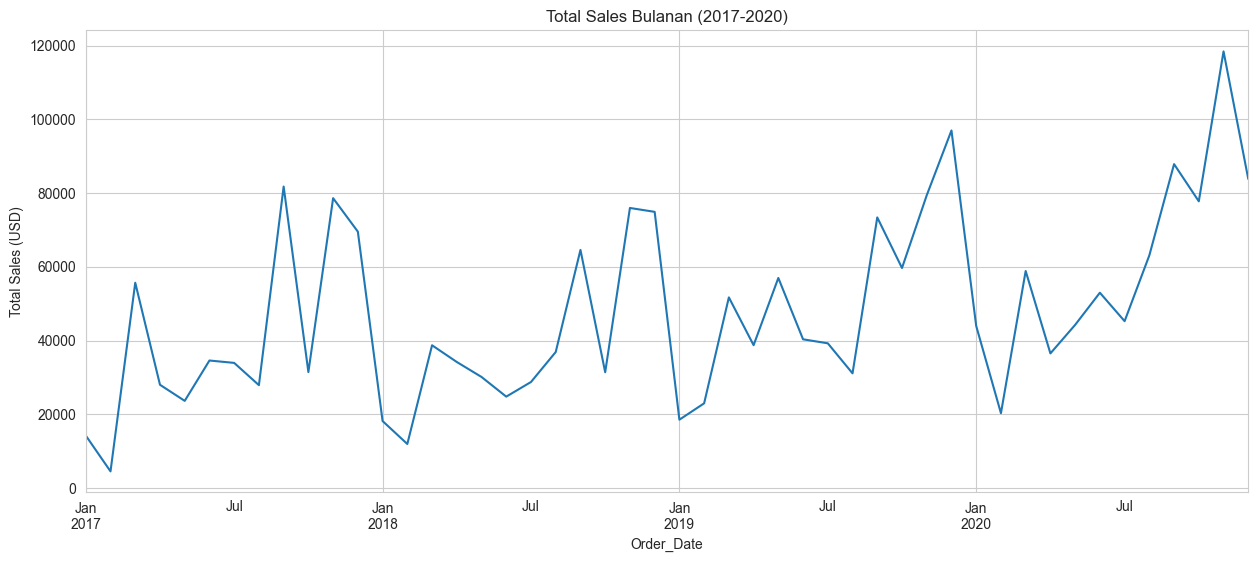

-> Grafik disimpan ke: ../reports/figures/6_ts_decomposition.png


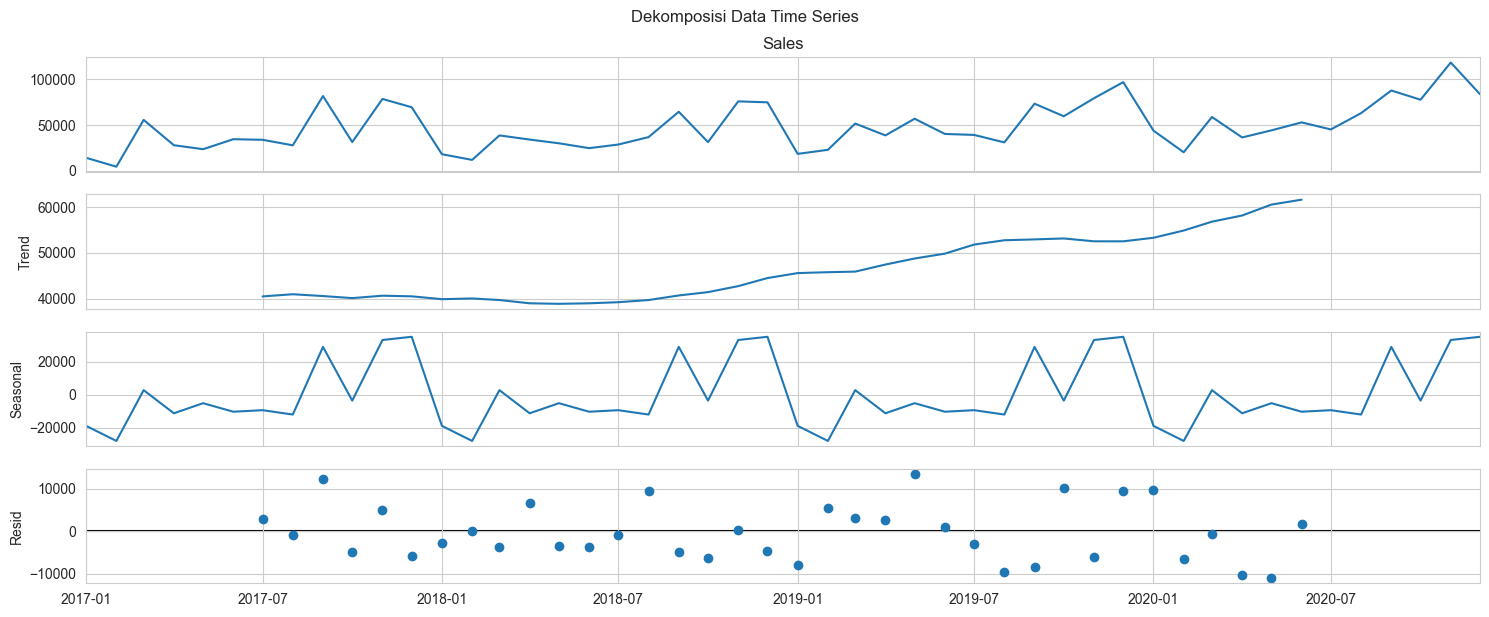

In [24]:
# Plot 1: Tren Bulanan
plt.figure() # Buat figure baru
ts_sales.plot(title='Total Sales Bulanan (2017-2020)', grid=True)
plt.ylabel('Total Sales (USD)')

# Simpan Gambar 1
file_simpan1 = os.path.join(figures_path, "5_ts_monthly_sales.png")
plt.savefig(file_simpan1, dpi=300, bbox_inches='tight')
print(f"-> Grafik disimpan ke: {file_simpan1}")
plt.show()


# Plot 2: Dekomposisi 
# Ini adalah baris yang error di tempat Anda. Pastikan Sel 1 sudah benar.
decomposition = seasonal_decompose(ts_sales, model='additive')
fig = decomposition.plot() # 'fig' adalah variabel untuk menyimpan plot
plt.suptitle('Dekomposisi Data Time Series', y=1.02)

# Simpan Gambar 2 
file_simpan2 = os.path.join(figures_path, "6_ts_decomposition.png")
fig.savefig(file_simpan2, dpi=300, bbox_inches='tight') # Simpan 'fig'
print(f"-> Grafik disimpan ke: {file_simpan2}")
plt.show()

<h1 style="color:lightblue;"><b><u>Split Data (Train & Test)</u></b></h1>

<h3 style="color:lightblue;">Kita tidak boleh pakai train_test_split! Data waktu harus berurutan. Kita akan pakai 12 bulan terakhir (tahun 2020) sebagai data tes.</h3>

Jumlah data Latih (Train): 36 bulan
Jumlah data Tes (Test): 12 bulan
-> Grafik disimpan ke: ../reports/figures/7_ts_train_test_split.png


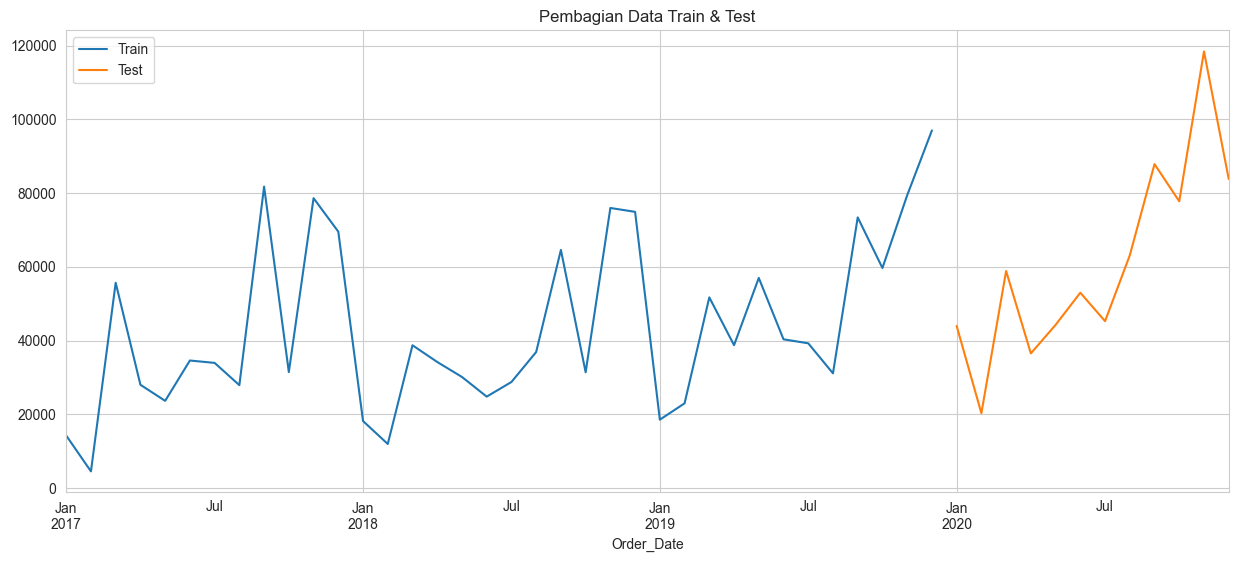

In [25]:
# Tentukan titik pisah (12 bulan terakhir untuk tes)
train_data = ts_sales.iloc[:-12]
test_data = ts_sales.iloc[-12:]

print(f"Jumlah data Latih (Train): {len(train_data)} bulan")
print(f"Jumlah data Tes (Test): {len(test_data)} bulan")

# Plot 3: Train vs Test
plt.figure()
train_data.plot(label='Train')
test_data.plot(label='Test')
plt.title('Pembagian Data Train & Test')
plt.legend()

# Simpan Gambar 3
file_simpan3 = os.path.join(figures_path, "7_ts_train_test_split.png")
plt.savefig(file_simpan3, dpi=300, bbox_inches='tight')
print(f"-> Grafik disimpan ke: {file_simpan3}")
plt.show()

<h1 style="color:lightblue;"><b><u>Latih Model (SARIMA)</u></b></h1>

<h3 style="color:lightblue;">Kita akan gunakan SARIMA: Seasonal AutoRegressive Integrated Moving Average. Ini adalah model yang sangat powerful untuk data musiman.
<p>- order=(1, 1, 1): Parameter non-musiman (p,d,q).</p>
- seasonal_order=(1, 1, 1, 12): Parameter musiman (P,D,Q,m). Angka 12 adalah kuncinya, artinya polanya berulang setiap 12 bulan.</h3>

In [26]:
print("Melatih model SARIMA... Ini mungkin butuh 1-2 menit.")

# Inisiasi model
# Kita berikan parameter (1,1,1) dan (1,1,1,12) sebagai tebakan awal yang baik
model_sarima = SARIMAX(
    train_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Latih model
results_sarima = model_sarima.fit()

print("Model SARIMA berhasil dilatih!")
print(results_sarima.summary()) # Tampilkan ringkasan statistik model

Melatih model SARIMA... Ini mungkin butuh 1-2 menit.
Model SARIMA berhasil dilatih!
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -96.268
Date:                            Sat, 01 Nov 2025   AIC                            202.537
Time:                                    17:40:48   BIC                            203.523
Sample:                                01-01-2017   HQIC                           200.409
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2634      0.6

c:\xampp\htdocs\Super Store\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<h1 style="color:lightblue;"><b><u>Evaluasi Model (Prediksi vs Data Tes)</u></b></h1>

<h3 style="color:lightblue;">Mari kita lihat seberapa baik model memprediksi tahun 2020 (data tes).</h3>

Membuat prediksi di data tes...
RMSE pada Data Tes: $16,253.93
-> Grafik disimpan ke: ../reports/figures/8_ts_sarima_evaluation.png


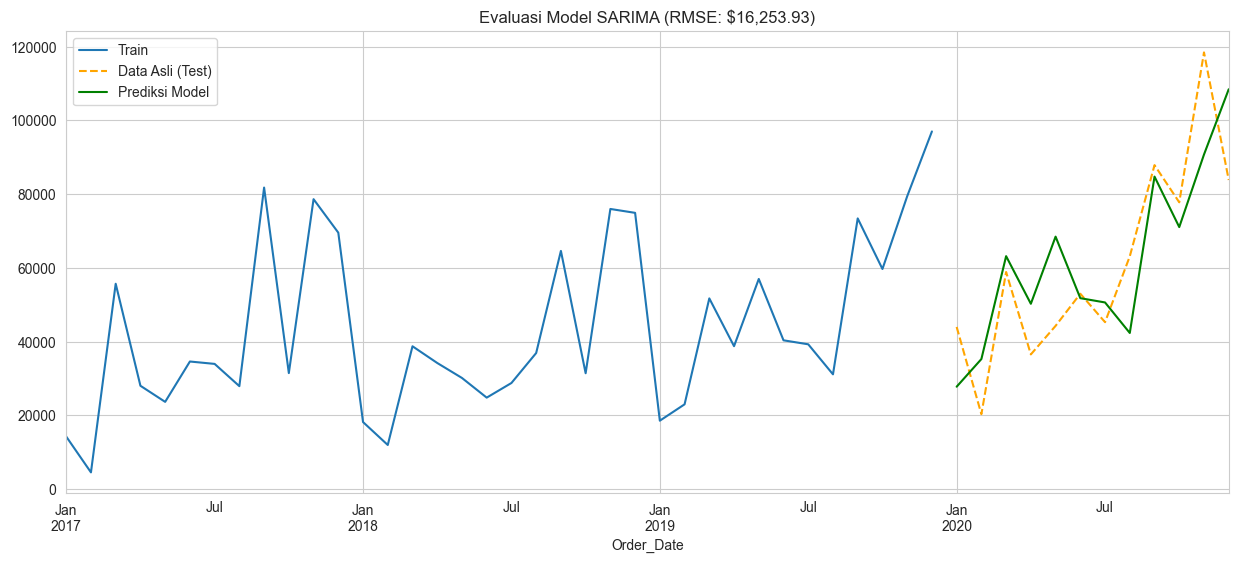

In [27]:
print("Membuat prediksi di data tes...")

start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = results_sarima.predict(start=start, end=end, dynamic=False)
predictions.index = test_data.index # Samakan index agar bisa di-plot

# Hitung error (RMSE)
# 1. Hitung MSE (Mean Squared Error) terlebih dahulu
mse = mean_squared_error(test_data, predictions)

# 2. Ambil akar kuadrat dari MSE untuk mendapatkan RMSE
rmse = mse**0.5
print(f"RMSE pada Data Tes: ${rmse:,.2f}")

# Plot 4: Evaluasi Model 
plt.figure()
train_data.plot(label='Train')
test_data.plot(label='Data Asli (Test)', style='--', color='orange')
predictions.plot(label='Prediksi Model', style='-', color='green')
plt.title(f'Evaluasi Model SARIMA (RMSE: ${rmse:,.2f})')
plt.legend()

# Simpan Gambar 4 
file_simpan4 = os.path.join(figures_path, "8_ts_sarima_evaluation.png")
plt.savefig(file_simpan4, dpi=300, bbox_inches='tight')
print(f"-> Grafik disimpan ke: {file_simpan4}")
plt.show()

<h1 style="color:lightblue;"><b><u>Forecast! (Memprediksi 6 Bulan ke Depan)</u></b></h1>

<h3 style="color:lightblue;">Kita akan melatih ulang model dengan SEMUA DATA (train + test) agar prediksinya lebih akurat.</h3>

In [28]:
print("Melatih ulang model dengan SEMUA data untuk forecasting...")

# Gunakan semua data (ts_sales)
final_model = SARIMAX(
    ts_sales, 
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_results = final_model.fit()

print("-> Model Final siap untuk forecast!")

# Buat prediksi 6 bulan ke depan
forecast_steps = 6
forecast = final_results.get_forecast(steps=forecast_steps)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int(alpha=0.05) # 95% confidence interval

print("\n--- Prediksi Sales 6 Bulan ke Depan ---")
print(pred_mean)

Melatih ulang model dengan SEMUA data untuk forecasting...
-> Model Final siap untuk forecast!

--- Prediksi Sales 6 Bulan ke Depan ---
2021-01-01    46499.657765
2021-02-01    41150.349650
2021-03-01    73671.540616
2021-04-01    58381.194815
2021-05-01    68505.790698
2021-06-01    63659.728139
Freq: MS, Name: predicted_mean, dtype: float64


c:\xampp\htdocs\Super Store\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<h1 style="color:lightblue;"><b><u>Visualisasi Forecast & Simpan Model</u></b></h1>

<h3 style="color:lightblue;">Mari kita plot prediksi masa depan kita.</h3>

-> Grafik disimpan ke: ../reports/figures/9_ts_final_forecast.png


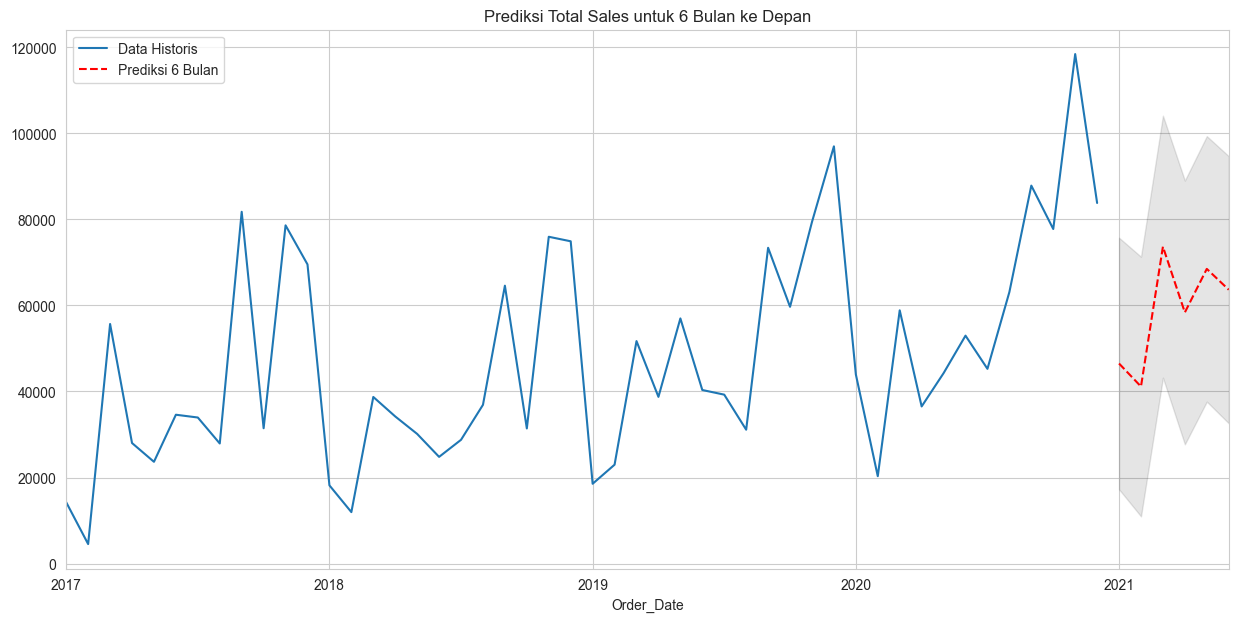


Model Time Series berhasil disimpan di: ../models/3_timeseries_sales_forecaster.joblib


In [29]:
# Plot 5: Final Forecast 
plt.figure()
ts_sales.plot(label='Data Historis', figsize=(15,7))
pred_mean.plot(label='Prediksi 6 Bulan', style='r--')

# Plot area interval kepercayaan (area abu-abu)
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0], # Batas bawah
    pred_ci.iloc[:, 1], # Batas atas
    color='k',
    alpha=0.1
)
plt.title('Prediksi Total Sales untuk 6 Bulan ke Depan')
plt.legend()

# Simpan Gambar 5
file_simpan5 = os.path.join(figures_path, "9_ts_final_forecast.png")
plt.savefig(file_simpan5, dpi=300, bbox_inches='tight')
print(f"-> Grafik disimpan ke: {file_simpan5}")
plt.show()

# Simpan Model Final 
model_path = "../models/"
os.makedirs(model_path, exist_ok=True) # Pastikan folder models ada
file_model_ts = os.path.join(model_path, "3_timeseries_sales_forecaster.joblib")

joblib.dump(final_results, file_model_ts)
print(f"\nModel Time Series berhasil disimpan di: {file_model_ts}")